In [12]:
from fastai.data.all import *
from fastai.vision.all import *

In [2]:
%matplotlib inline

In [47]:
im_path = Path('GatherData/data/pic/src/640/base/')

df = pd.read_csv('GatherData/data/base_meta.csv', index_col = 0)

In [48]:
df[['y1','y2','x1','x2']] = df[['y1','y2','x1','x2']].round(0)

In [65]:
df['point_ol'] = df.apply(lambda x: [x['y1'],x['x1']], axis = 1)
df['point_ur'] = df.apply(lambda x: [x['y2'],x['x2']], axis = 1)

In [59]:
fn = x[0]

im1 = plt.imread(fn)
im2 = plt.imread(str(fn).replace('640','orig'))

In [64]:
df[df['fname'] == fn.name]

,fname,y1,y2,x1,x2,label,project,background,angle,groups,usability,orientation,point_bl,point_tr
728,base_incorrect_green2_21.JPG,70.0,2917.0,903.0,5459.0,incorrect,base,green2,top,179,ok,R,"[70.0, 903.0]","[2917.0, 5459.0]"


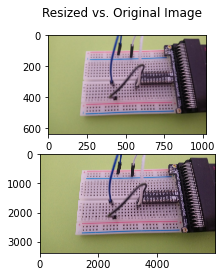

In [57]:
fig, axs = plt.subplots(2)
fig.suptitle('Resized vs. Original Image')
axs[0].imshow(im1)
axs[1].imshow(im2)

In [51]:
x = get_image_files(im_path)

In [50]:
df.head()

,fname,y1,y2,x1,x2,label,project,background,angle,groups,usability,orientation,point_bl,point_tr
0,base_correct_black_1.JPG,70.0,559.0,125.0,908.0,correct,base,black,side,1,ok,L,"[70.0, 125.0]","[559.0, 908.0]"
1,base_correct_black_2.JPG,146.0,567.0,203.0,877.0,correct,base,black,top,1,ok,L,"[146.0, 203.0]","[567.0, 877.0]"
2,base_correct_black_3.JPG,37.0,575.0,150.0,1012.0,correct,base,black,top,1,ok,R,"[37.0, 150.0]","[575.0, 1012.0]"
3,base_correct_black_4.JPG,51.0,619.0,94.0,1003.0,correct,base,black,side,1,ok,R,"[51.0, 94.0]","[619.0, 1003.0]"
4,base_correct_black_5.JPG,26.0,602.0,57.0,979.0,correct,base,black,side,2,ok,R,"[26.0, 57.0]","[602.0, 979.0]"


In [73]:
def get_df(df, val_method = 'groups', background = None, val_pct = 0.2, 
           angle = None, unique = True, orientation = None, verbose = True):
    df_ok = df[df.usability == 'ok'].copy()
    
    if angle:
        assert(angle in ['top', 'side']), 'Pick a valid angle'
        if verbose: print('Reduce the dataframe to only {} angle photos'.format(angle))
        df_ok = df_ok[df_ok.angle == angle]
   
    if orientation:
        assert(orientation in ['L','R']), 'Pick a valid orientation'
        if verbose: print('Reduce the dataframe to only {} oriented photos'. format(orientation))
        df_ok = df_ok[df_ok.orientation == orientation]
        
    groups = np.array(df_ok.groups.unique())
    
    if val_method == 'background': # the model is validated on an unseen background
        if verbose: print('Build the validation set by background')
        if background not in df_ok.background.unique():
            background = random.choice(df_ok.background.unique())
            if verbose: print('Pick the background {} at random'.format(background))
        else:
            if verbose: print('Pick the background {}'.format(background))
            
        is_valid = df_ok.background == background
        
    elif val_method == 'groups': # the model is validated on unseen groups
        if verbose: print('Building the validation set from groups, picking {}% of the groups at random'.format(val_pct * 100))
        total_groups = len(groups) 
        val_no = int(val_pct * total_groups)
        
        is_valid = df_ok.groups.isin(np.random.choice(groups, val_no))
    
    else:
        if verbose: print('Pick a valid validation method')
        return None
    
    df_ok['is_valid'] = is_valid    
    
    if unique: # all instances of a group are considered for validation
        if verbose: print('Reduce the dataframe, so for every group in the training there is only one unique item')
        df_unique = pd.DataFrame(columns = df_ok.columns)
        for group in groups: # in none of the validation methods, a group should appear in both training and validation set
            df_tmp = df_ok[df_ok.groups == group]
            if df_tmp.iloc[0]['is_valid']:
                df_unique = df_unique.append(df_tmp, ignore_index = True)
            else:
                df_unique = df_unique.append(df_tmp.sample(1), ignore_index = True)
        df_ok = df_unique
   
    print('Total items: {} of which the in validation set: {} '.format(df_ok.shape[0], df_ok.is_valid.sum()))
    return df_ok[['fname','point_bl','point_tr','is_valid']]

def get_blocks(size, trans_mult = 1.):
    dBlock = DataBlock(blocks = (ImageBlock, PointBlock, PointBlock),
                       splitter = RandomSplitter(),
                       get_x = lambda x: f'{im_path}/'+ x.fname,
                       get_y = [lambda x: tensor(x['point_bl']).flip(0), lambda x: tensor(x['point_tr']).flip(0)], #ColReader('point_bl'),
                       item_tfms = Resize((640, int(640 * 1.6)), method = 'squash', pad_mode = 'zeros'),
                       batch_tfms = aug_transforms(size = (size, int(size * 1.6)),
                                                   max_rotate = 10.,
                                                   min_zoom = 0.95,
                                                   max_zoom = 1.05,
                                                   p_affine = 0.8,
                                                   p_lighting = 0.8,
                                                   max_lighting = 0.3,
                                                   max_warp = 0.0,
                                                   mult = trans_mult
                                                  ),
                       n_inp = 1
                      )
    return dBlock

def get_learner(size = 224, bs = None, arch = resnet34):
    if not bs:
        bs = int(64 * 224 / size)
        
    blks = get_blocks(size)
    df_res = get_df(df, 
                    angle = 'side', 
                    orientation = None,
                    val_pct = 0.2,
                    val_method = 'background', 
                    background = 'black',
                    unique = True,
                    verbose = False)
    
    dls = blks.dataloaders(df_res, bs = bs)
    
    return cnn_learner(dls, arch, metrics=accuracy).to_fp16(), dls

In [74]:
blks = get_blocks(224)
df_res = get_df(df)

Building the validation set from groups, picking 20.0% of the groups at random
Reduce the dataframe, so for every group in the training there is only one unique item
Total items: 357 of which the in validation set: 146 


In [75]:
dls = blks.dataloaders(df_res, bs = 64)

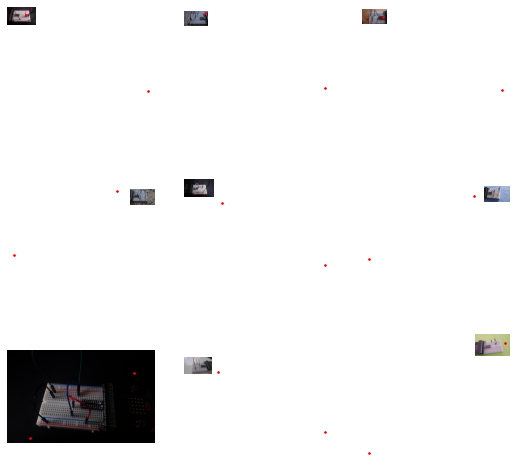

In [76]:
dls.show_batch()

In [77]:
learn = cnn_learner(dls, resnet34).to_fp16()

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=1.5848931980144698e-06)

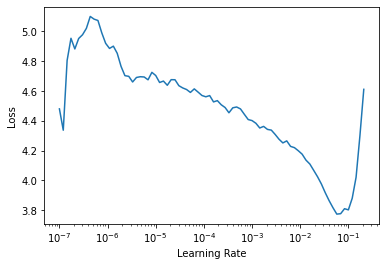

In [70]:
learn.lr_find()

In [78]:
learn.fine_tune(5, 5e-3)

TypeError: 'L' object is not callable